In [70]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import io
import sagemaker.amazon.common as smac
import sagemaker
import boto3
from sagemaker.predictor import csv_serializer, json_deserializer

%matplotlib inline
plt.style.use('seaborn')


## Setup

In [63]:
bucket = 'sagemaker-testi-tl'
prefix = 'ais-test'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

## Data

In [5]:
!wget https://www.dropbox.com/s/8xey3kf4i1tl62c/sample-linear-regression.csv?dl=1

--2018-08-16 10:03:20--  https://www.dropbox.com/s/8xey3kf4i1tl62c/sample-linear-regression.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.1, 2620:100:6020:1::a27d:4001
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/8xey3kf4i1tl62c/sample-linear-regression.csv [following]
--2018-08-16 10:03:21--  https://www.dropbox.com/s/dl/8xey3kf4i1tl62c/sample-linear-regression.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc76e0b6dda0dba44b0611f29f29.dl.dropboxusercontent.com/cd/0/get/AOFSpQuzbbQAawoRGCC0h4qmQfCeEmIl8z8jMFmzNwkwWtAC04eS77d7UPMEGEuWjSpzcx2ZJyBBe7DdEy1kFQmwP0k_hy_8bSijkTMNQ9TiN4um4rWw6gjEbi8IeXBw28GzzuqW5OgZ-FS94MqDUJuo-bMvWReHrhiR7ym2h7qsPaut_zdoU63ypqrNkL_NjBk/file?dl=1 [following]
--2018-08-16 10:03:21--  https://uc76e0b6dda0dba44b0611f29f29.dl.dropboxusercontent.com/cd/0/ge

In [7]:
df = pd.read_csv("sample-linear-regression.csv?dl=1", sep=",")
df

,timestamp,mmsi,lon,lat,sog,cog,heading
0,2018-03-19 07:16:03.114,266232000,24.286427,65.184065,13.7,92.8,92
1,2018-03-19 07:17:03.202,266232000,24.295677,65.184068,14.2,88.1,89
2,2018-03-19 07:18:02.787,266232000,24.304790,65.184032,14.0,90.8,90
3,2018-03-19 07:18:56.815,266232000,24.313237,65.183982,14.1,91.4,91
4,2018-03-19 07:19:50.959,266232000,24.321113,65.183747,13.6,93.0,93
5,2018-03-19 07:21:38.54,266232000,24.337000,65.183530,13.1,93.0,93


,lat,lon
0,65.184065,24.286427
1,65.184068,24.295677
2,65.184032,24.304790
3,65.183982,24.313237
4,65.183747,24.321113
5,65.183530,24.337000


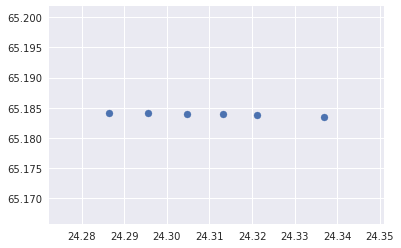

In [12]:
df = df[['lat', 'lon']]
display(plt.scatter('lon', 'lat', data=df))
display(df)

In [49]:
train_y = df['lat']
train_X = df[['lon']].as_matrix()

In [52]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(train_X).astype('float32'), np.array(train_y).astype('float32'))
buf.seek(0)

0

In [58]:
key = 'ais_test_train.data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-testi-tl/ais-test/train/ais_test_train.data


In [59]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')
container

'438346466558.dkr.ecr.eu-west-1.amazonaws.com/linear-learner:1'

In [66]:
sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path='s3://{}/{}/output'.format(bucket, prefix),
                                       sagemaker_session=sess)
linear.set_hyperparameters(feature_dim=1,
                           mini_batch_size=5,
                           predictor_type='regressor',
                           epochs=10,
                           num_models=32,
                           loss='absolute_loss')

linear.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2018-08-16-11-06-17-450


.....................

Docker entrypoint called with argument(s): train
[08/16/2018 11:09:35 INFO 140006476932928] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u'target_recall': u'0.8', u'num_models': u'auto', u'early_stopping_patience': u'3', u'momentum': u'auto', u'unbias_label': u'auto', u'wd': u'auto', u'optimizer': u'auto', u'_tuning_objective_metric': u'', u'early_stopping_tolerance': u'0.001', u'learning_rate': u'auto', u'_kvstore': u'auto', u'normalize_data': u'true', u'binary_c

Billable seconds: 98


## Deploy

In [67]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2018-08-16-11-11-13-213
INFO:sagemaker:Creating endpoint with name linear-learner-2018-08-16-11-06-17-450


--------------------------------------------------------------!

In [71]:
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [72]:
result = linear_predictor.predict([24.33])
result


{'predictions': [{'score': 65.23909759521484}]}